In [1]:
%ls

BenJackCode/             hmmbase.py               pybasicbayes/
README.md                hmmbatchcd.py            setup.py
VI-sandbox/              hmmbatchsgd.py           sgd_tests.ipynb
__pycache__/             hmmsgd_metaobs.py        test_hmmbatchcd.py
build/                   hsmm_plots.ipynb         test_hmmbatchsgd.py
change_notes.txt         hsmmbase.py              test_hmmsgd_metaobs.py
experiments.ipynb        hsmmbatchcd.py           test_hsmmbatchcd.py
fdr.pyx                  hsmmbatchsgd.py          test_hsmmbatchsgd.py
generate_data.py         hsmmsgd_metaobs.py       test_hsmmsgd_metaobs.py
hmm_fast.pyx             matrix_expansion.py      util.py
hmm_plots.ipynb          munkres.py


In [4]:
import numpy as np
from pybasicbayes import distributions as dist
from pybasicbayes.distributions import Gaussian
import matplotlib.pyplot as plt
from generate_data import *
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchcd as HMM
import seaborn as sns
from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *
from sklearn.cluster import KMeans
import time 
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmsgd_metaobs as HMMSGD

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *

from pybasicbayes import distributions as dist
from generate_data import *

from sklearn.cluster import KMeans

import stan
import numpy as np
import nest_asyncio


/Users/lenkasefcakova/Desktop/variational-inf-for-HSMM/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/Users/lenkasefcakova/Desktop/variational-inf-for-HSMM/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


In [5]:
centers = np.array([np.array([0,0]),np.array([6,0]),np.array([4,4]),np.array([0,6]),np.array([12,8])])

K = 5           # number of states  
D = 2        #have to be equal (symmetry)
kappa_0 = 0.5     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

T = np.array([
    [0.89,0.01,0.01,0.05,0.04],
    [0.05,0.8,0.05,0.05,0.05],
    [0.05,0.1,0.7,0.05,0.1],
    [0.1,0.1,0.05,0.7,0.05],
    [0.025,0.025,0.025,0.025,0.9]
    ])

N = 3000

emit = make_emissions(centers , kappa_0, nu_0)


seq, ind = generate_states(T,N)

obs = generate_data(emit,ind)

kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=42)
kmeans.fit(obs)

mu_0 = kmeans.cluster_centers_

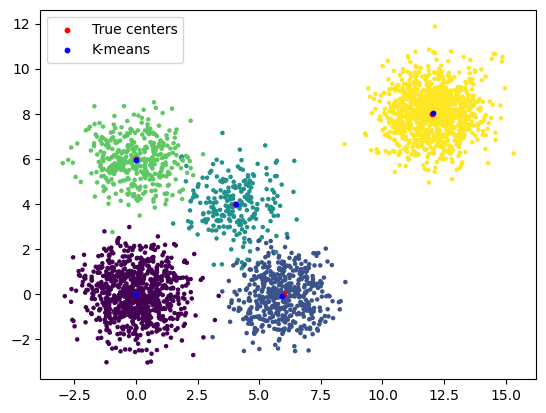

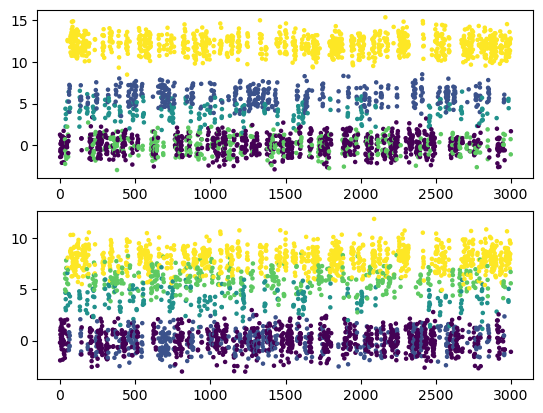

In [6]:
plt.scatter(obs[:,0],obs[:,1],  s=5, c =seq)
plt.scatter(centers[:,0],centers[:,1], s=10, c='red',label = 'True centers')
plt.scatter(mu_0[:,0],mu_0[:,1], s=10, c='blue', label = 'K-means')
plt.legend()
plt.show()

fig, axs = plt.subplots(2, 1)

axs[0].scatter([i for i in range(N)],obs[:,0],s=5, c =seq )
axs[1].scatter([i for i in range(N)],obs[:,1],s=5, c =seq )

In [7]:
mu_0 = kmeans.cluster_centers_ #np.zeros(D)
sigma_0 = 0.75*np.cov(obs.T)
kappa_0 = 10 # high value for stability (low rescale when Gaussian mu_0 --> mu_mf resample(--> nat_to_standard()))
# if we use the KMeans we are pretty confident in the centers so we can set a high value
nu_0 = 4


# define emisssion RV for each state (2)
prior_emit = [Gaussian(mu_0=mu_0[i], sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for i in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_tran = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
prior_init = np.ones(K)                     # ?
print(prior_emit[0].mu_mf)

[11.32213175  7.75747607]


True
terminated early - convergence, 
 elbo : -15531146.80912481 
 lower bound : -15531146.809124824
allclose  = True, diff : 1.30385160446167e-08
[11.32213175  7.75747607]
Hamming Distance =  0.3486666666666667


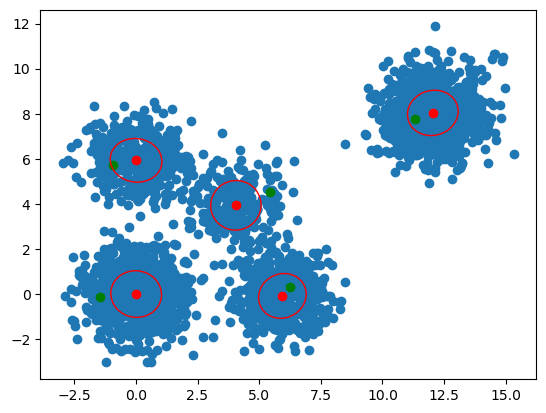

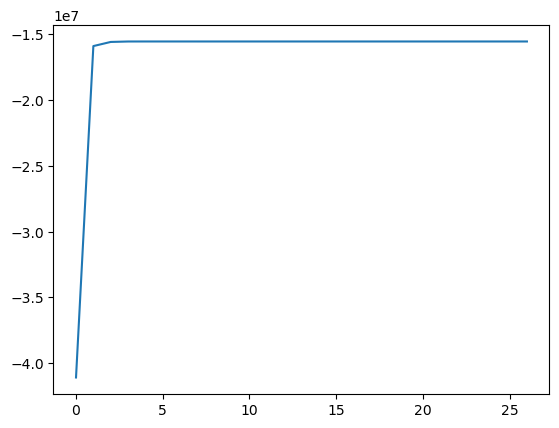

time is:  2.7035889625549316


In [8]:
# FULL BATCH
# define object for inferrence from hmmbatchcd.py
# pass priors on init transitions and emissions for each state
hmm = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit,maxit=100, epsilon=10**(-7))  
start_time = time.time()
hmm.infer() # do inference 
end_time = time.time()
sts_true = seq # true states 
# hamming distance
print(prior_emit[0].mu_mf)
print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
a = util.plot_emissions(obs, prior_emit, hmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm.elbo_vec)
plt.show()
elapsed_time_VB = end_time - start_time 
print('time is: ',elapsed_time_VB)

Hamming Distance =  0.3486666666666667


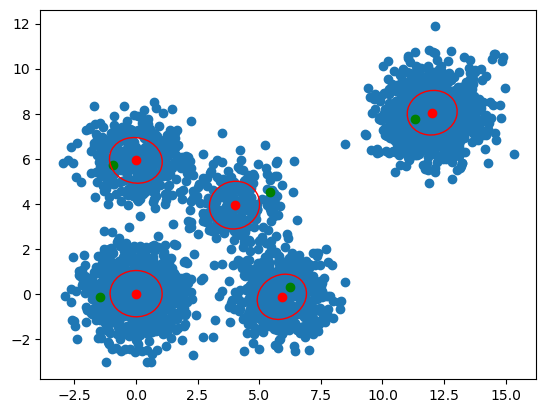

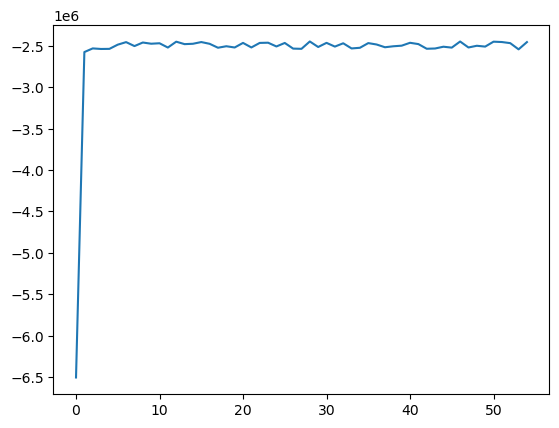

time is:  2.378970146179199


In [9]:
#  BATCH SGD VI
maxit = 55
metaobs_half = 600
mb_sz = 1

hmm_sgd = HMMSGD.VBHMM(obs, prior_init, prior_tran, prior_emit, maxit=maxit, metaobs_half=metaobs_half, mb_sz=mb_sz)
start_time = time.time()
hmm_sgd.infer()
end_time = time.time()

full_var_x = hmm_sgd.full_local_update()

# hamming distance
print('Hamming Distance = ', hmm_sgd.hamming_dist(full_var_x, seq)[0])

# plot learned emissions over observations
util.plot_emissions(obs, prior_emit, hmm_sgd.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm_sgd.elbo_vec)
plt.show()
elapsed_time_SGDVB = end_time - start_time 
print('time is: ',elapsed_time_SGDVB)

In [11]:
# STAN

nest_asyncio.apply()
mu_0_ = KMeans(init="random",n_clusters=1,n_init=10,max_iter=300,random_state=42).fit(obs).cluster_centers_[0]
dat = [tuple(i) for  i in obs]
data = {'y':dat , "N": N, "D":D, "K":K, 'mu_0':mu_0_ , 'kappa_0':kappa_0/K, 'nu_0':nu_0,'Psi_0':sigma_0,'alpha_0':np.ones((K,K))} #specify dirichlet prior [1,1,1,...] on transitions

# read code from .stan file 
with open('BenJackCode/MvNormEmis_HMM.stan') as f:
    stan_code = f.read()

# build stan model 
jack_model = stan.build(stan_code,data)

N_MCMC = 1000 

# start sampling
start_time = time.time()
fit = jack_model.sample(num_chains = 1, num_samples = 1000+N_MCMC, num_warmup = 1000 )
end_time = time.time()

elapsed_time_MCMC = end_time - start_time 

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_56a2ctxi/model_bggfrf6v.stan', line 10, column 50: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_56a2ctxi/model_bggfrf6v.stan', line 10, column 62: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_56a2ctxi/model_bggfrf6v.stan', line 11, column 26: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Ins

In [12]:
print(elapsed_time_MCMC)

820.254400730133


In [13]:
#plot preparation

# for every state extract parameters into a dict 
from scipy.stats import invwishart,t,beta

MCMC_mus = {}
MCMC_sig = {}
MCMC_gamm = {}

true_map_MCMC = [np.argmin(np.sqrt(np.sum((np.mean(fit['mu'][i].T, axis =0)-centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(fit['mu'].shape[0]):
    MCMC_mus[str(true_map_MCMC[i])] = fit['mu'][i].T
    MCMC_sig[str(true_map_MCMC[i])] = fit['Sigma'][i].T
    MCMC_gamm[str(true_map_MCMC[i])] = {}
    for j in range(fit['mu'].shape[0]):
        MCMC_gamm[str(true_map_MCMC[i])][str(true_map_MCMC[j])] = fit['gamma'][i].T[:,j]

VI_mus = {}
VI_sig = {}
VI_kapp = {}
VI_nu = {}
VI_alphas = {}

true_map_VI = [np.argmin(np.sqrt(np.sum((hmm.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(0,len(hmm.var_emit)):
    VI_mus[str(true_map_VI[i])] = hmm.var_emit[i].mu_mf
    VI_sig[str(true_map_VI[i])] = hmm.var_emit[i].sigma_mf
    VI_kapp[str(true_map_VI[i])] = hmm.var_emit[i].kappa_mf
    VI_nu[str(true_map_VI[i])] = hmm.var_emit[i].nu_mf
    VI_alphas[str(true_map_VI[i])] = {}
    for j in range(0,len(hmm.var_emit)):
        VI_alphas[str(true_map_VI[i])][str(true_map_VI[j])] = hmm.var_tran[i][j]
        
SVI_mus = {}
SVI_sig = {}
SVI_kapp = {}
SVI_nu = {}
SVI_alphas = {}

true_map_SVI = [np.argmin(np.sqrt(np.sum((hmm_sgd.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(0,len(hmm_sgd.var_emit)):
    SVI_mus[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].mu_mf
    SVI_sig[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].sigma_mf
    SVI_kapp[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].kappa_mf
    SVI_nu[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].nu_mf
    SVI_alphas[str(true_map_SVI[i])] = {}
    for j in range(0,len(hmm_sgd.var_emit)):
        SVI_alphas[str(true_map_SVI[i])][str(true_map_SVI[j])] = hmm_sgd.var_tran[i][j]

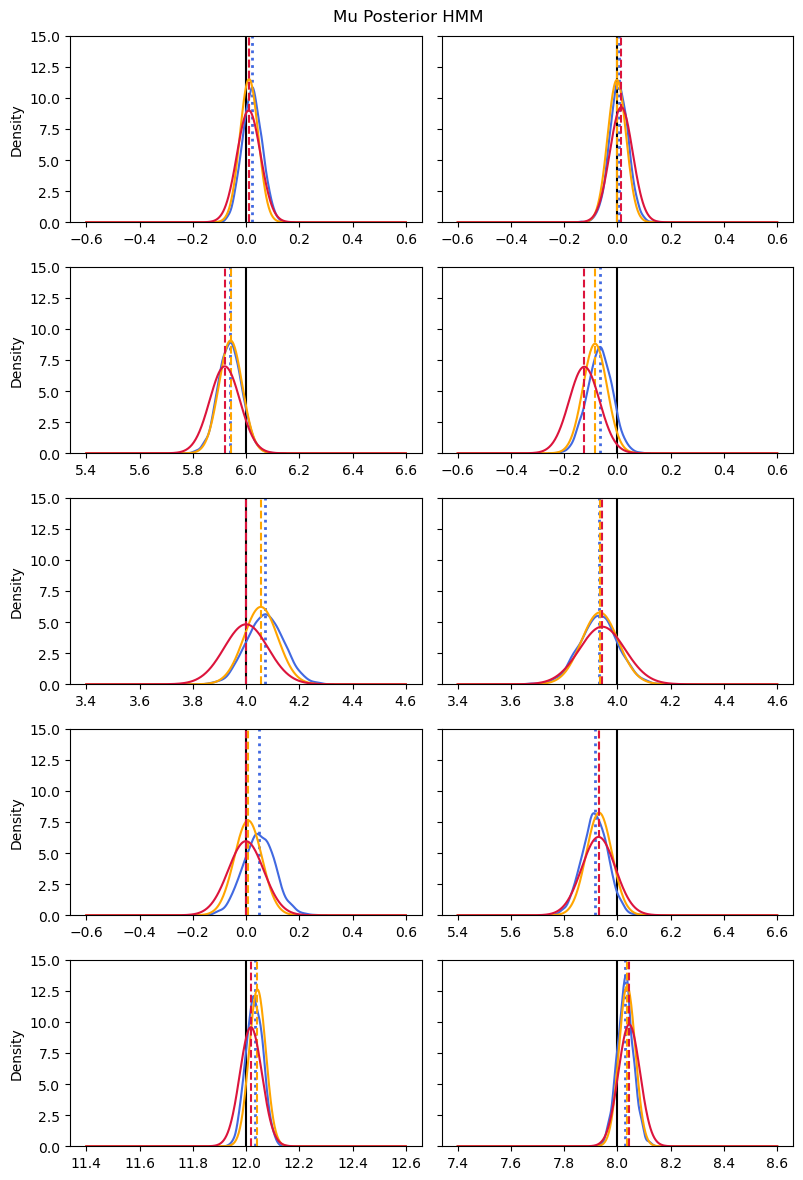

In [14]:
K=5
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey=True)
D=2
for k in range(K):
    for d in range(D):

        ax = axs[k,d]

        ax.vlines(centers[k][d],0,20,color = 'black',label='truth')
# MCMC
        ax.vlines(np.mean(MCMC_mus[str(k+1)].T[d]),0,20,color = 'royalblue',linestyles='dotted',linewidth = 2, label='MCMC mean')
        sns.kdeplot(MCMC_mus[str(k+1)].T[d],label='MCMC density',ax=ax,color = 'royalblue')

# VI
        x = np.linspace(centers[k][d]-0.6,centers[k][d]+0.6,500)
        scale_kd = np.diag(VI_sig[str(k+1)])[d] / (VI_kapp[str(k+1)]*( VI_nu[str(k+1)] + D - 1 ))
        
        ax.plot(x, t.pdf(x, df = VI_nu[str(k+1)], loc=VI_mus[str(k+1)][d], scale=np.sqrt(scale_kd)),label = 'VI',color = 'orange')
        ax.vlines(VI_mus[str(k+1)][d],0,20,color = 'orange',label='VI mean',linestyles='dashed')

# SVI
        scale_kd = np.diag(SVI_sig[str(k+1)])[d] / (SVI_kapp[str(k+1)]*( SVI_nu[str(k+1)] + D - 1 ))
        
        dist2 = t.pdf(x, df = SVI_nu[str(k+1)], loc=SVI_mus[str(k+1)][d], scale=np.sqrt(scale_kd))

        ax.plot(x, dist2,label = 'SVI',color = 'crimson')

        ax.vlines(SVI_mus[str(k+1)][d],0,15,color = 'crimson',label='SVI',linestyles='dashed')

        plt.ylim((0,15))
plt.suptitle('Mu Posterior HMM')
plt.ylabel('State i')
# legend = plt.legend(fontsize = 8)
plt.tight_layout()



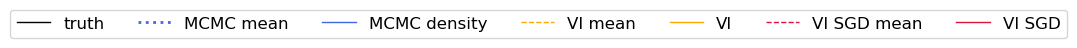

In [15]:
fig_legend, ax_legend = plt.subplots(figsize=(8, 0.5))
ax_legend.axis('off')

# Create a legend for the desired elements
legend_elements = [
    plt.Line2D([0], [0], color='black', linewidth=1, label='truth'),
    plt.Line2D([0], [0], color='royalblue', linewidth=2, linestyle='dotted', label='MCMC mean'),
    plt.Line2D([0], [0], color='royalblue', linewidth=1, label='MCMC density'),
    plt.Line2D([0], [0], color='orange', linewidth=1, label='VI mean', linestyle='dashed'),
    plt.Line2D([0], [0], color='orange', linewidth=1, label='VI'),
    plt.Line2D([0], [0], color='crimson', linewidth=1, label='VI SGD mean', linestyle='dashed'),
    plt.Line2D([0], [0], color='crimson', linewidth=1, label='VI SGD'),
]

# Plot the legend
ax_legend.legend(handles=legend_elements, loc='center', fontsize=12, ncol=7)
plt.tight_layout()
plt.show()

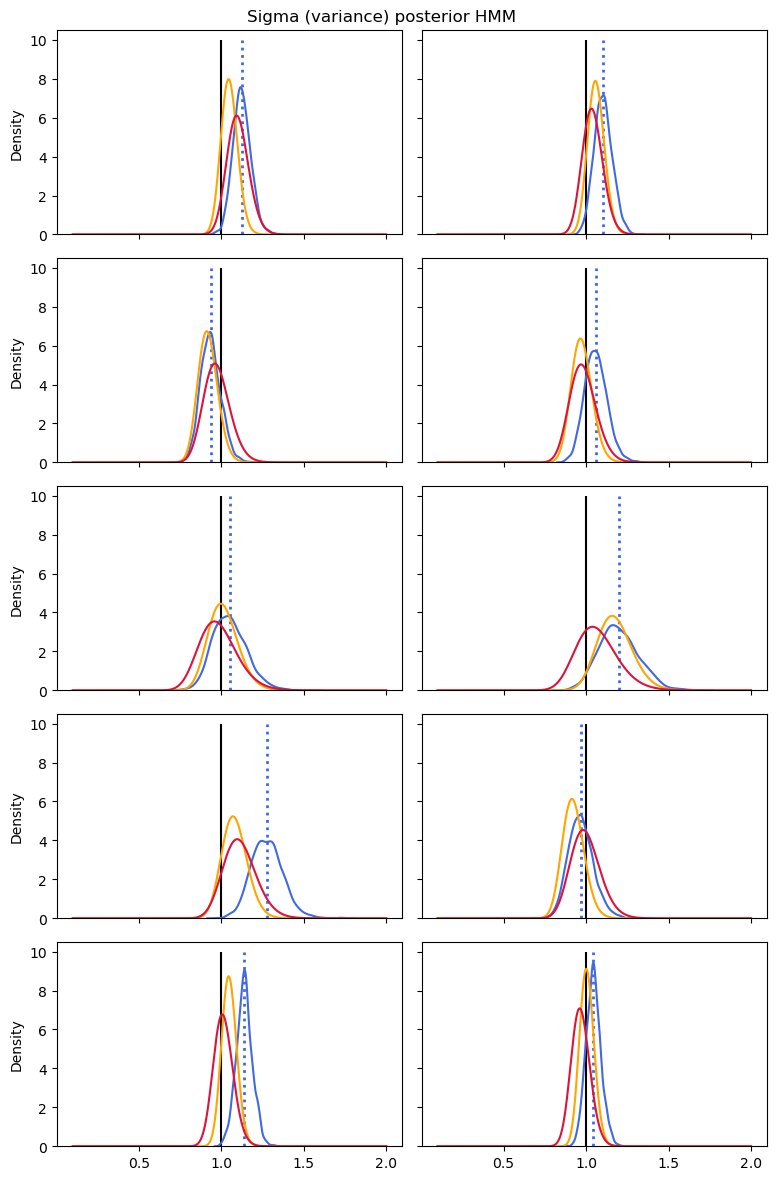

In [16]:
from scipy.stats import invwishart
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey = True,sharex=True)
for k in range(K):
    for d in range(D):

        ax = axs[k,d]

        ax.vlines(1,0,10,color = 'black',label='truth')


        ax.vlines(np.mean(MCMC_sig[str(k+1)][:][:,d,d]),0,10,color = 'royalblue',linestyles='dotted',linewidth = 2, label='MCMC mean')

        sns.kdeplot(MCMC_sig[str(k+1)][:][:,d,d],label='MCMC density',ax=ax,color = 'royalblue')

        x = np.linspace(0.1,2,500)
        iw = invwishart.pdf(x, df=VI_kapp[str(k+1)], scale = np.diag(VI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'VI I-Wishart',color = 'orange')
        
        iw = invwishart.pdf(x, df=SVI_kapp[str(k+1)], scale = np.diag(SVI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'SVI',color = 'crimson')
        
        # ax.sharex(axs[:][d][0])

plt.suptitle('Sigma (variance) posterior HMM')
# plt.legend(fontsize = 8)
plt.tight_layout()

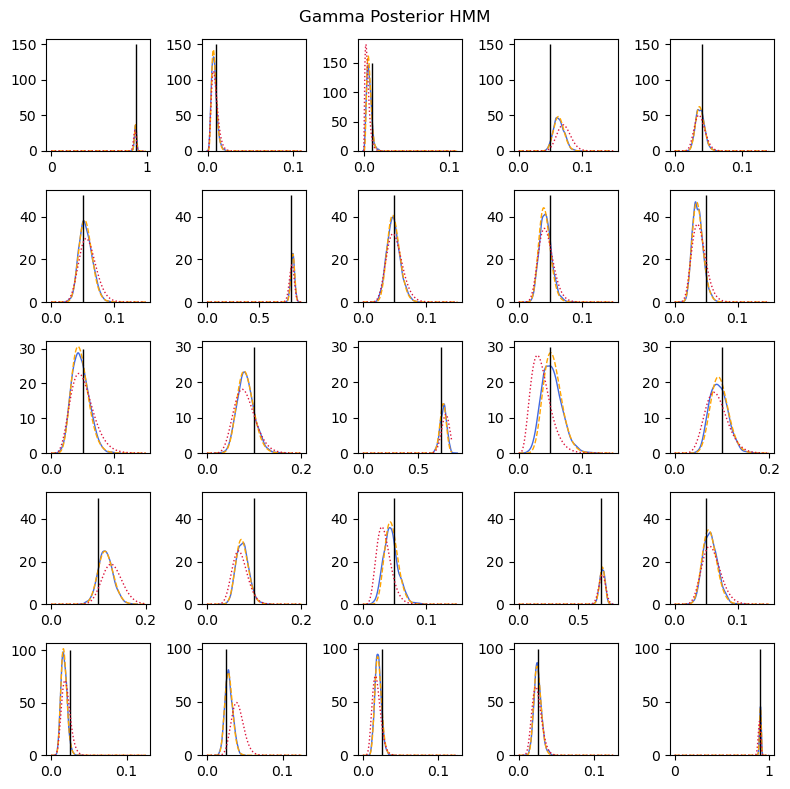

In [26]:
K=5
heights = [150,50,30,50,100]
fig, axs = plt.subplots(K, K,figsize=(8, 8))#,sharey=  True,sharex=  True
for k in range(K):
    for j in range(K):
        ax = axs[k,j]
        sns.kdeplot(MCMC_gamm[str(k+1)][str(j+1)],label='MCMC density',ax=ax,linewidth=1.0, color = 'royalblue')

        x = np.linspace(0,T[k][j]  + 0.1,500)

        dist = beta.pdf(x,VI_alphas[str(k+1)][str(j+1)] , sum(VI_alphas[str(k+1)].values())-VI_alphas[str(k+1)][str(j+1)])

        ax.plot(x, dist,label = 'VI beta',color = 'orange',linewidth=1.0,linestyle = 'dashed')

        ax.vlines(T[k][j],0,heights[k],color = 'black',label='truth',linewidth=1.0)

        #SVI
        dist2 = beta.pdf(x,SVI_alphas[str(k+1)][str(j+1)] , sum(SVI_alphas[str(k+1)].values())-SVI_alphas[str(k+1)][str(j+1)])
        ax.plot(x, dist2,label = 'SVI beta',color = 'crimson',linewidth=1.0,linestyle = 'dotted')
        
        # ax.set_xlim(0,1)
        ax.set(ylabel=None)


plt.suptitle('Gamma Posterior HMM')
# plt.legend(fontsize = 8)
plt.tight_layout()

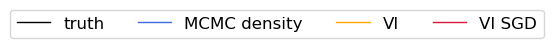

In [29]:
fig_legend, ax_legend = plt.subplots(figsize=(6, 0.5))
ax_legend.axis('off')

# Create a legend for the desired elements
legend_elements = [
    plt.Line2D([0], [0],linewidth=1.0, color = 'black',label='truth'),
    plt.Line2D([0], [0], color='royalblue', linewidth=1.0, label='MCMC density'),
    plt.Line2D([0], [0], color='orange', linewidth=1.0, label='VI'),
    plt.Line2D([0], [0],
    linewidth=1.0, color = 'crimson',label='VI SGD')
]

# Plot the legend
ax_legend.legend(handles=legend_elements, loc='center', fontsize=12,ncol=4)
plt.tight_layout()
plt.show()